In [351]:
# Problem Set3
# Wanlin Ji

# Import packages and load the data
import numpy as np
import pandas as pd
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

incomes = np.loadtxt('./incomes.txt')
# pts

Now let's define a criterion function that takes as inputs the parameters and the estimator for the weighting matrix $\hat{W}$.

In [243]:
# Define function that generates values of a truncated normal pdf
def trunc_norm_pdf(xvals, mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the truncated normal pdf with mean mu and
    standard deviation sigma. If the cutoff is finite, then the PDF
    values are inflated upward to reflect the zero probability on values
    above the cutoff. If there is no cutoff given or if it is given as
    infinity, this function does the same thing as
    sp.stats.norm.pdf(x, loc=mu, scale=sigma).
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    prob_notcut = scalar 
    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: 
    pdf_vals
    --------------------------------------------------------------------
    '''
    if cutoff == 'None':
        prob_notcut = 1.0
    else:
         prob_notcut = sts.norm.cdf(np.log(cutoff), loc=mu, scale=sigma)
        
    pdf_vals    = ( (1/(sigma * np.sqrt(2 * np.pi) * xvals) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

In [234]:
# assitant functions
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    var_data  = scalar > 0, variance of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    var_data = xvals.var()
    
    return mean_data, var_data


def model_moments(mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()
        xfx()
        x2fx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_model = scalar, mean value of test scores from model
    m_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the mean of the distribution
    var_model  = scalar > 0, variance of test scores from model
    v_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the variance of the distribution
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_model, var_model
    --------------------------------------------------------------------
    '''
    xfx = lambda x: x * trunc_norm_pdf(x, mu, sigma, cutoff)
    (mean_model, m_m_err) = intgr.quad(xfx, 0, cutoff)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_norm_pdf(x, mu, sigma, cutoff) 
    (var_model, v_m_err) = intgr.quad(x2fx, 0, cutoff)
    
    return mean_model, var_model


def err_vec(xvals, mu, sigma, cutoff, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma, cutoff)
    moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [299]:
def data_moments3(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the four data moments for GMM
    (binpct_1, binpct_2, binpct_3)
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None

    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_dat = scalar in [0, 1], percent of observations
                 0 <= x < 75000
    bpct_2_dat = scalar in [0, 1], percent of observations
                 75000 <= x <= 100000
    bpct_3_dat = scalar in [0, 1], percent of observations
                  x > 100000

    FILES CREATED BY THIS FUNCTION: None

    RETURNS: bpct_1, bpct_2, bpct_3
    --------------------------------------------------------------------
    '''
    bpct_1_dat = xvals[xvals < 75000].shape[0] / (xvals.shape[0]*1.0)
    bpct_2_dat = xvals[(xvals >=75000) & (xvals <= 100000)].shape[0] /(xvals.shape[0] * 1.0)
    bpct_3_dat = xvals[xvals > 100000].shape[0] * 1.0 / (xvals.shape[0] * 1.0)
    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments3(mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    This function computes the four model moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()
        xfx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_mod = scalar in [0, 1], percent of model observations in
                 bin 1
    bp_1_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_1_mod
    bpct_2_mod = scalar in [0, 1], percent of model observations in
                 bin 2
    bp_2_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_2_mod
    bpct_3_mod = scalar in [0, 1], percent of model observations in
                 bin 3
    bp_3_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_3_mod
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: bpct_1_mod, bpct_2_mod, bpct_3_mod
    --------------------------------------------------------------------
    '''
    xfx = lambda x: trunc_norm_pdf(x, mu, sigma, cutoff)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000,  100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 140000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec3(xvals, mu, sigma, cutoff, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments4()
        model_moments4()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    bpct_1_dat, bpct_2_dat, bpct_3_dat = \
        data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod= \
        model_moments3(mu, sigma, cutoff)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec


def criterion3(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        err_vec3()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (3, 1) matrix, column vector of three moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec3(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

#  question 1

## (a)

<IPython.core.display.Javascript object>


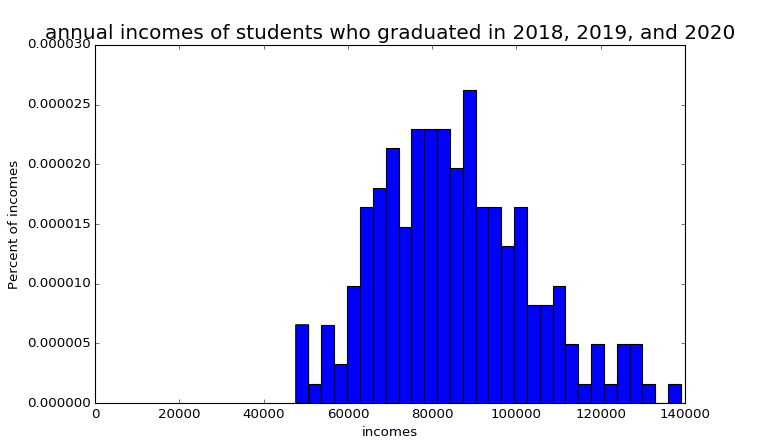

In [383]:
# Plot the histogram of the data
%matplotlib notebook
count, bins, ignored = plt.hist(income, 30, normed=True)
plt.title('annual incomes of students who graduated in 2018, 2019, and 2020', fontsize=18)
plt.xlabel('incomes')
plt.ylabel('Percent of incomes')
plt.xlim([0, 140000])  # This gives the xmin and xmax to be plotted"
plt.show()

## (b)

In [87]:
print 'the mean of incomes: %s' %np.mean(incomes)
print 'the standard deviation of incomes: %s' %np.std(incomes)

the mean of incomes: 85276.8236063
the standard deviation of incomes: 17992.542128


Now we can perform the GMM estimation. Let's start with the identity matrix as our estimate for the optimal weighting matrix $W = I$.

In [390]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init = 9
sig_init = 0.3
params_init = np.array([mu_init, sig_init])
W_hatB = np.eye(2)
gmm_args = (incomes, 140000, W_hatB)

resultsB = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMMB, sig_GMMB = resultsB.x
print('mu_GMMB=', mu_GMMB, ' sig_GMMB=', sig_GMMB)

('mu_GMMB=', 11.337109190940749, ' sig_GMMB=', 0.2192527544843165)


In [400]:
print(data_moments(incomes))
print(model_moments(mu_GMMB, sig_GMMB, 140000))
params = np.array([mu_GMMB, sig_GMMB])
print(criterion(params, incomes, 140000, W_hatB))

(85276.823606258113, 323731572.2295289)
(85276.82616084014, 323731560.7624381)
[[  2.15207252e-15]]


In [391]:
mean_data, var_data = data_moments(incomes)
mean_model, var_model = model_moments(mu_GMMB, sig_GMMB, 140000.0)
err1 = err_vec(incomes, mu_GMMB, sig_GMMB, 140000.0, False).reshape(2,)

print('Mean of incomes =', mean_data, ', Variance of incomes =', var_data)
print('Mean of model =', mean_model, ', Variance of model =', var_model)
#print('Error vector=', err1)
resultsB

('Mean of incomes =', 85276.823606258113, ', Variance of incomes =', 323731572.2295289)
('Mean of model =', 85276.82616084014, ', Variance of model =', 323731560.7624381)


      fun: array([[  2.15207252e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.42435824e-09,   6.10616049e-09])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 222
      nit: 20
   status: 0
  success: True
        x: array([ 11.33710919,   0.21925275])

Let's plot the PDF implied by these results against the histogram.

<IPython.core.display.Javascript object>


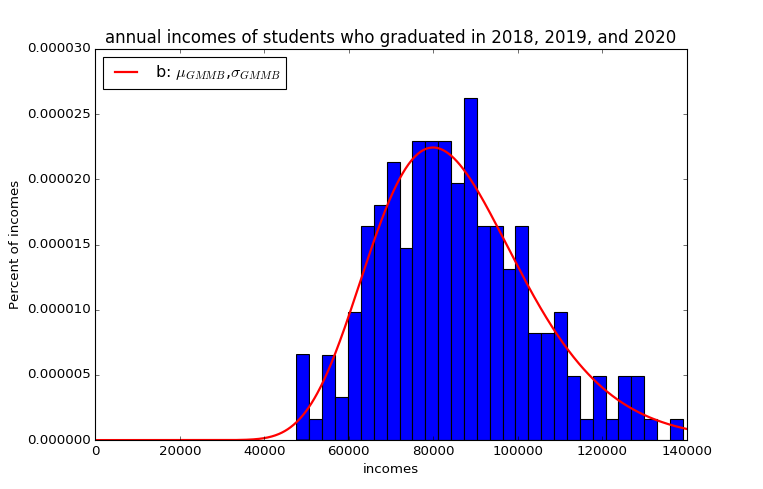

In [384]:
# Plot the histogram of the data
%matplotlib notebook
count, bins, ignored = plt.hist(income, 30, normed=True)
plt.title('annual incomes of students who graduated in 2018, 2019, and 2020', fontsize=15)
plt.xlabel('incomes')
plt.ylabel('Percent of incomes')
plt.xlim([0, 140000])  # This gives the xmin and xmax to be plotted"

# Plot the estimated GMM PDF
dist_incomes = np.linspace(0, 140000, 1000)
plt.plot(dist_incomes, trunc_norm_pdf(dist_incomes, mu_GMMB, sig_GMMB, 140000),
         linewidth=2, color='r', label='b: $\mu_{GMMB}$,$\sigma_{GMMB}$')
plt.legend(loc='upper left')
plt.show()

## (c)

In [392]:
errC = err_vec(incomes, mu_GMMB, sig_GMMB, 140000.0, False)
VCVC = np.dot(errC, errC.T) / incomes.shape[0]
print(VCVC)
W_hatC = lin.pinv(VCVC)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hatC)

[[  4.48691330e-18  -5.30550875e-18]
 [ -5.30550875e-18   6.27344931e-18]]
[[  3.87519771e+16  -4.58219136e+16]
 [ -4.58219136e+16   5.41816941e+16]]


In [393]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init =  11
sig_init = 0.1
params_init = np.array([mu_GMMB, sig_GMMB])
# W_hat3 = np.array([[1. / VCV2[0, 0], 0.], [0., 1. / VCV2[1, 1]]])
gmm_args = (incomes, 140000.0, W_hatC)
resultsC = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (None, None)))
mu_GMMC, sig_GMMC = resultsC.x
print('mu_GMMC=', mu_GMMC, ' sig_GMMC=', sig_GMMC)

('mu_GMMC=', 11.337109191207636, ' sig_GMMC=', 0.21925275795472635)


In [395]:
mean_data, var_data = data_moments(incomes)
mean_model, var_model = model_moments(mu_GMMC, sig_GMMC, 140000.0)
err1 = err_vec(incomes, mu_GMMC, sig_GMMC, 140000.0, False).reshape(2,)

print('Mean of incomes =', mean_data, ', Variance of incomes =', var_data)
print('Mean of model =', mean_model, ', Variance of model =', var_model)
#print('Error vector=', err1)
resultsC

('Mean of incomes =', 85276.823606258113, ', Variance of incomes =', 323731572.2295289)
('Mean of model =', 85276.8261807724, ', Variance of model =', 323731568.9079436)


      fun: array([[ 69.41160749]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -8.64594589e+08,   6.64906576e+07])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 132
      nit: 1
   status: 2
  success: False
        x: array([ 11.33710919,   0.21925276])

<IPython.core.display.Javascript object>


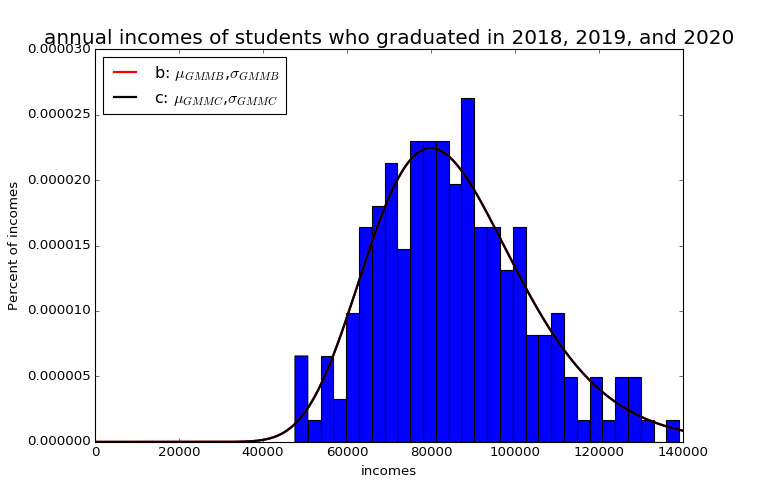

In [396]:
# Plot the histogram of the data
%matplotlib notebook
count, bins, ignored = plt.hist(income, 30, normed=True)
plt.title('annual incomes of students who graduated in 2018, 2019, and 2020', fontsize=18)
plt.xlabel('incomes')
plt.ylabel('Percent of incomes')
plt.xlim([0, 140000])  # This gives the xmin and xmax to be plotted"

# Plot the estimated GMM PDF from part (b)
dist_incomes = np.linspace(0, 140000, 1000)
plt.plot(dist_incomes, trunc_norm_pdf(dist_incomes, mu_GMMB, sig_GMMB, 140000),
         linewidth=2, color='r', label='b: $\mu_{GMMB}$,$\sigma_{GMMB}$')

# Plot the estimated GMM PDF from part (c)
plt.plot(dist_incomes, trunc_norm_pdf(dist_incomes, mu_GMMC, sig_GMMC, 140000),
         linewidth=2, color='k', label='c: $\mu_{GMMC}$,$\sigma_{GMMC}$')

plt.legend(loc='upper left')
plt.show()

## (d)

In [301]:
print(data_moments3(incomes))
print(model_moments3(10, 0.2, 140000.0))
params = np.array([9, 0.3])
print(criterion3(params, incomes, 140000.0, np.eye(3)))

(0.3, 0.5, 0.2)
(0.9999999995500353, 4.4994591322412076e-10, 1.944889686984479e-14)
[[ 74444.44444443]]


In [340]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hatD = np.eye(3)
# W_hat[1, 1] = 2.0
# W_hat[2, 2] = 2.0
gmm_args = (pts, 140000.0, W_hatD)
resultsD = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMMD, sig_GMMD = resultsD.x
print('mu_GMMD=', mu_GMMD, ' sig_GMMD=', sig_GMMD)

('mu_GMMD=', 11.338533709249997, ' sig_GMMD=', 0.21313332028526361)


In [402]:
print(data_moments3(incomes))
print(model_moments3(mu_GMMD, sig_GMMD, 140000.0))
params = np.array([mu_GMMD, sig_GMMD])
print(criterion3(params, incomes, 140000.0, np.eye(3)))

(0.3, 0.5, 0.2)
(0.3000000033098537, 0.5000000060166191, 0.19999999067352683)
[[  2.44110005e-11]]


<IPython.core.display.Javascript object>


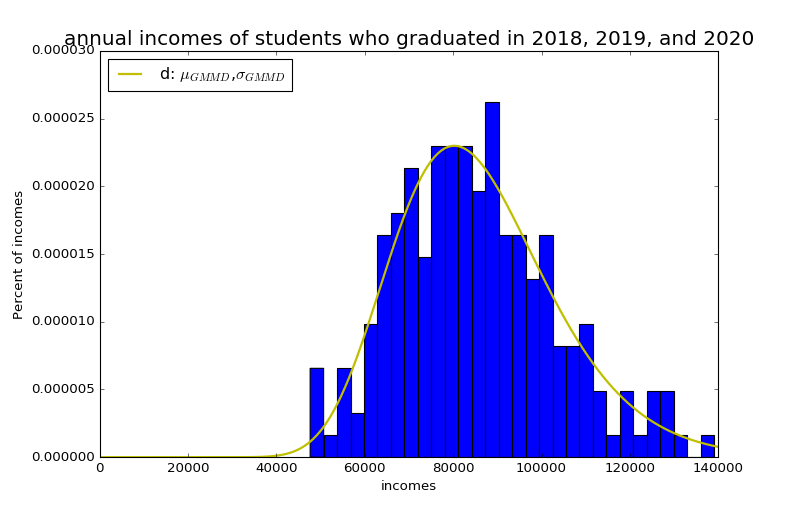

In [397]:
# Plot the histogram of the data
%matplotlib notebook
count, bins, ignored = plt.hist(income, 30, normed=True)
plt.title('annual incomes of students who graduated in 2018, 2019, and 2020', fontsize=18)
plt.xlabel('incomes')
plt.ylabel('Percent of incomes')
plt.xlim([0, 140000])  # This gives the xmin and xmax to be plotted"


# Plot the estimated GMM PDF from part (d)
plt.plot(dist_incomes, trunc_norm_pdf(dist_incomes, mu_GMMD, sig_GMMD, 140000),
         linewidth=2, color='y', label='d: $\mu_{GMMD}$,$\sigma_{GMMD}$')

plt.legend(loc='upper left')
plt.show()

## (e)

In [342]:
errE = err_vec3(pts, mu_GMMD, sig_GMMD, 140000.0, False)
VCVE = np.dot(err_e, err_e.T) / incomes.shape[0]
print(VCVE)
W_hatE = lin.pinv(VCVE)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hatE)

[[  6.08618427e-15   6.63804304e-15  -2.57243850e-14]
 [  6.63804304e-15   7.23994106e-15  -2.80569183e-14]
 [ -2.57243850e-14  -2.80569183e-14   1.08728877e-13]]
[[  4.08539382e+11   4.45583288e+11  -1.72676736e+12]
 [  4.45583288e+11   4.85986115e+11  -1.88334029e+12]
 [ -1.72676736e+12  -1.88334029e+12   7.29850205e+12]]


In [343]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init = 11
sig_init = 0.6
params_init = np.array([mu_GMMD, sig_GMMD])
gmm_args = (incomes, 140000.0, W_hatE)
resultsE = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMME, sig_GMME = resultsE.x
print('mu_GMME=', mu_GMME, ' sig_GMME=', sig_GMME)
resultsE

('mu_GMME=', 11.338533711060952, ' sig_GMME=', 0.21313332245459343)


      fun: array([[ 60.13483577]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  9.06827463e+09,  -3.54915659e+09])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 183
      nit: 4
   status: 0
  success: True
        x: array([ 11.33853371,   0.21313332])

In [407]:
print(data_moments3(incomes))
print(model_moments3(mu_GMME, sig_GMME, 140000.0))
params = np.array([mu_GMME, sig_GMME])
print(criterion3(params, incomes, 140000.0, W_hatE))

(0.3, 0.5, 0.2)
(0.3000000024562819, 0.5000000026260845, 0.1999999949176335)
[[ 60.13483577]]


<IPython.core.display.Javascript object>


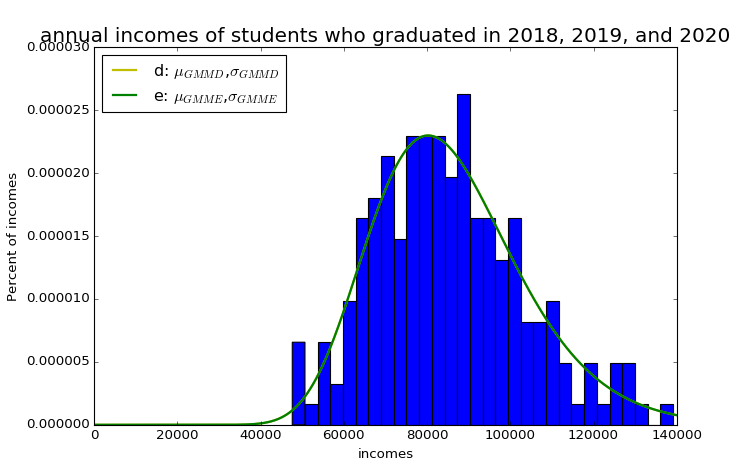

In [403]:
# Plot the histogram of the data from (a)
%matplotlib notebook
count, bins, ignored = plt.hist(income, 30, normed=True)
plt.title('annual incomes of students who graduated in 2018, 2019, and 2020', fontsize=18)
plt.xlabel('incomes')
plt.ylabel('Percent of incomes')
plt.xlim([0, 140000])  # This gives the xmin and xmax to be plotted"

# Plot the estimated GMM PDF from part (d)
dist_incomes = np.linspace(0, 140000, 1000)
plt.plot(dist_incomes, trunc_norm_pdf(dist_incomes, mu_GMMD, sig_GMMD, 140000),
         linewidth=2, color='y', label='d: $\mu_{GMMD}$,$\sigma_{GMMD}$')

# Plot the estimated GMM PDF from part (e)
plt.plot(dist_incomes, trunc_norm_pdf(dist_incomes, mu_GMME, sig_GMME, 140000),
         linewidth=2, color='g', label='e: $\mu_{GMME}$,$\sigma_{GMME}$')

plt.legend(loc='upper left')
plt.show()

## (f)

<IPython.core.display.Javascript object>


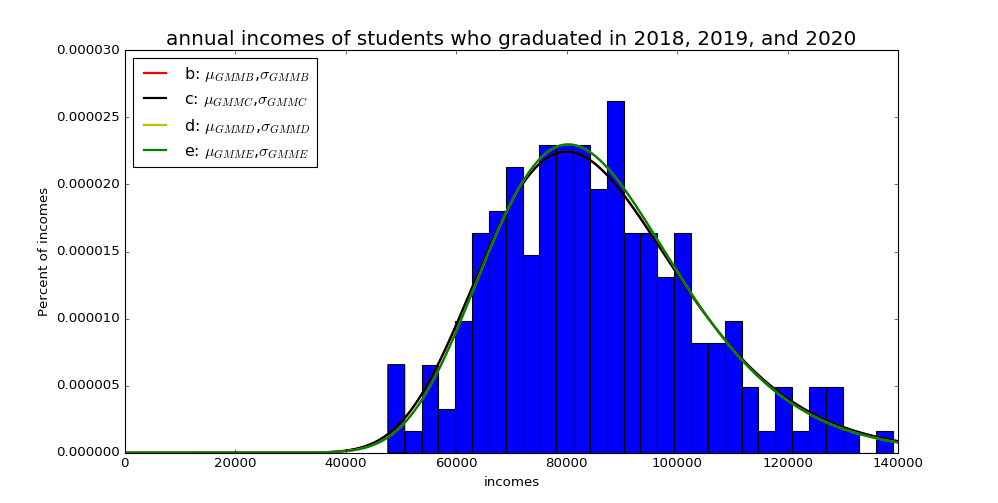

In [408]:
# Plot the histogram of the data from (a)
%matplotlib notebook
count, bins, ignored = plt.hist(income, 30, normed=True)
plt.title('annual incomes of students who graduated in 2018, 2019, and 2020', fontsize=18)
plt.xlabel('incomes')
plt.ylabel('Percent of incomes')
plt.xlim([0, 140000])  # This gives the xmin and xmax to be plotted"

# Plot the estimated GMM PDF from part (b)
dist_incomes = np.linspace(0, 140000, 1000)
plt.plot(dist_incomes, trunc_norm_pdf(dist_incomes, mu_GMMB, sig_GMMB, 140000),
         linewidth=2, color='r', label='b: $\mu_{GMMB}$,$\sigma_{GMMB}$')

# Plot the estimated GMM PDF from part (c)
plt.plot(dist_incomes, trunc_norm_pdf(dist_incomes, mu_GMMC, sig_GMMC, 140000),
         linewidth=2, color='k', label='c: $\mu_{GMMC}$,$\sigma_{GMMC}$')


# Plot the estimated GMM PDF from part (d)
dist_incomes = np.linspace(0, 140000, 1000)
plt.plot(dist_incomes, trunc_norm_pdf(dist_incomes, mu_GMMD, sig_GMMD, 140000),
         linewidth=2, color='y', label='d: $\mu_{GMMD}$,$\sigma_{GMMD}$')

# Plot the estimated GMM PDF from part (e)
plt.plot(dist_incomes, trunc_norm_pdf(dist_incomes, mu_GMME, sig_GMME, 140000),
         linewidth=2, color='g', label='e: $\mu_{GMME}$,$\sigma_{GMME}$')

plt.legend(loc='upper left')
plt.show()

# question 2

## (a)

In [381]:
def err_ols(data, *betas):
    b0, b1, b2, b3 = betas
    label = data.sick
    model = b0 + b1 * data.age + b2 * data.children + b3 * data.avgtemp_winter
    err_vec = label - model
    return (err_vec)

def criterion_ols(params, args):
    data = args
    W = np.eye(len(data))
    err = err_ols(data, *params)
    crit_val = np.dot(np.dot(err.T, W), err)
    return (crit_val)

In [382]:
sick_data = pd.read_csv('sick.txt', encoding = 'utf-8-sig') # Read in CS
params = np.array([0, 0, 0, 0])
results = opt.minimize(criterion_ols,  params, args=sick_data, method = 'L-BFGS-B')
beta_vec = results.x
print('Beta estimates b1, b2, b3, b4 are: %s' %beta_vec)

print('Criterion function value with GMM estimates = %s'
      %criterion_ols(np.array(beta_vec), sick_data) )

Beta estimates b1, b2, b3, b4 are: [ 0.25164554  0.01293354  0.40050037 -0.00999177]
Criterion function value with GMM estimates = 0.0018212898156
